<a href="https://colab.research.google.com/github/BADS7604Group03/assignment3/blob/main/code/RNN_Encoder_Decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Prepare the environment

In [1]:
# List all NVIDIA GPUs as available in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-c27c2272-2e5e-cef3-c8a2-22b18552db6f)


In [2]:
import sys
print(f'Python {sys.version}\n')

import numpy as np
print(f'NumPy {np.__version__}\n')

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print(f'TensorFlow {tf.__version__}')
print(f'tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}')

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print(f'TensorFlow detected {len(gpus)} GPU(s):')
for i, gpu in enumerate(gpus):
  print(f'....GPU No. {i}: Name = {gpu.name}, Type = {gpu.device_type}')

import os
import math
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Set fixed seeding values for reproducability during experiments
# To guarantee reproducability, make sure that seed values for ANY randomize operation are all set
np.random.seed(1234)
tf.random.set_seed(5678)

Python 3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]

NumPy 1.21.5

TensorFlow 2.8.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
....GPU No. 0: Name = /physical_device:GPU:0, Type = GPU


# 2. Create the Encoder-Decoder RNN model

Model: "seq2seq_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input_x (InputLayer)   [(None, None, 1)]    0           []                               
                                                                                                  
 decoder_input_x (InputLayer)   [(None, None, 1)]    0           []                               
                                                                                                  
 encoder_rnn (SimpleRNN)        [(None, 20),         440         ['encoder_input_x[0][0]']        
                                 (None, 20)]                                                      
                                                                                                  
 decoder_rnn (SimpleRNN)        [(None, None, 20),   440         ['decoder_input_x[0][

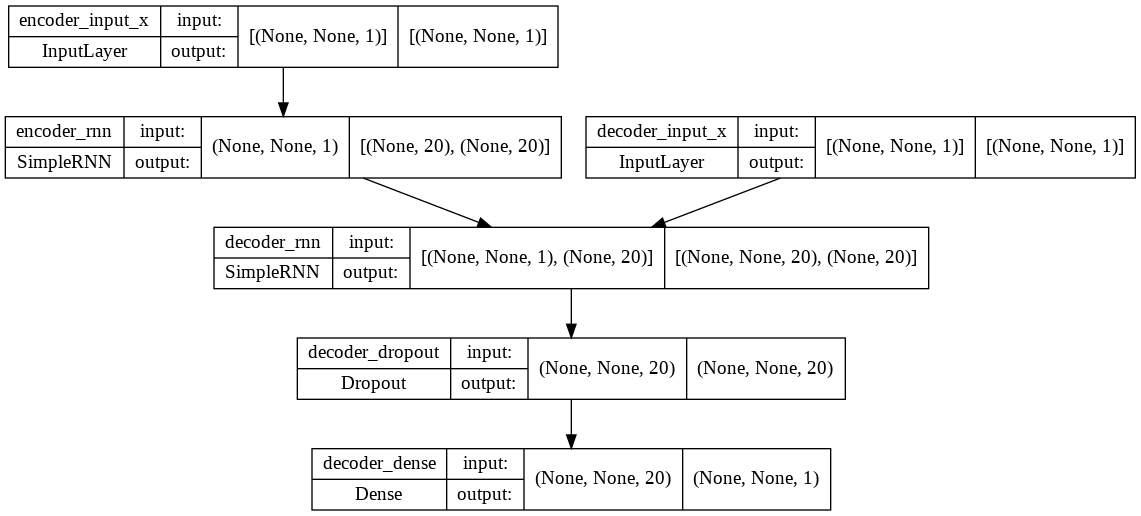

In [3]:
n_input, n_output, n_units = 1, 1, 20

encoder_inputs = tf.keras.layers.Input(shape=(None, n_input), name='encoder_input_x')
encoder_rnn = tf.keras.layers.SimpleRNN(n_units, return_state=True, name='encoder_rnn')

encoder_outputs, encoder_states = encoder_rnn(encoder_inputs)

decoder_inputs = tf.keras.layers.Input(shape=(None, n_output), name='decoder_input_x')
decoder_rnn = tf.keras.layers.SimpleRNN(n_units, return_sequences=True, return_state=True, name='decoder_rnn')
decoder_dropout = tf.keras.layers.Dropout(0.3, name='decoder_dropout')
decoder_dense = tf.keras.layers.Dense(n_output, name='decoder_dense')

decoder_outputs, _ = decoder_rnn(decoder_inputs, initial_state=encoder_states)
decoder_outputs = decoder_dropout(decoder_outputs)
decoder_outputs = decoder_dense(decoder_outputs)

seq2seq_model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs, name='seq2seq_model')
seq2seq_model.summary()

tf.keras.utils.plot_model(seq2seq_model, 'Group_HW3_trainmodel.png', show_shapes=True, show_dtype=False, show_layer_names=True, dpi=96)

## 2.2 Create separated decoder and encoder for inferencing

Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input_x (InputLayer  [(None, None, 1)]        0         
 )                                                               
                                                                 
 encoder_rnn (SimpleRNN)     [(None, 20),              440       
                              (None, 20)]                        
                                                                 
Total params: 440
Trainable params: 440
Non-trainable params: 0
_________________________________________________________________


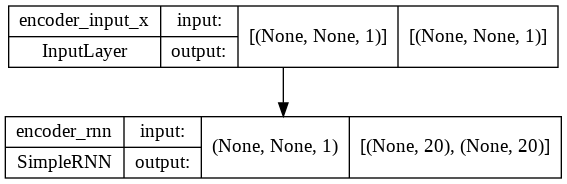

In [4]:
encoder_model = tf.keras.Model(inputs=encoder_inputs, outputs=encoder_states, name='encoder_model')

encoder_model.summary()
tf.keras.utils.plot_model(encoder_model, 'Group_HW3_encodermodel.png', show_shapes=True, show_dtype=False, show_layer_names=True, dpi=96)

Model: "decoder_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input_x (InputLayer)   [(None, None, 1)]    0           []                               
                                                                                                  
 decoder_input_state (InputLaye  [(None, 20)]        0           []                               
 r)                                                                                               
                                                                                                  
 decoder_rnn (SimpleRNN)        [(None, None, 20),   440         ['decoder_input_x[0][0]',        
                                 (None, 20)]                      'decoder_input_state[0][0]']    
                                                                                      

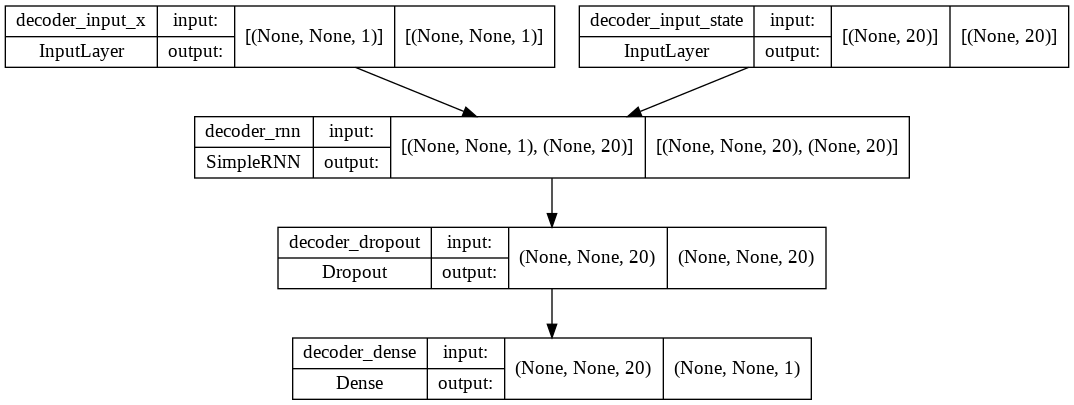

In [5]:
decoder_states_inputs = tf.keras.layers.Input(shape=(n_units), name='decoder_input_state')

decoder_outputs, decoder_states = decoder_rnn(decoder_inputs, initial_state=decoder_states_inputs)
decoder_outputs = decoder_dropout(decoder_outputs)
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = tf.keras.Model(inputs=[decoder_inputs] + [decoder_states_inputs],
                               outputs=[decoder_outputs] + [decoder_states],
                               name='decoder_model')

decoder_model.summary()
tf.keras.utils.plot_model(decoder_model, 'Group_HW3_decodermodel.png', show_shapes=True, show_dtype=False, show_layer_names=True, dpi=96)

# 3. Prepare Data


## 3.1 Load Data

In [6]:
path = '/content/drive/MyDrive/Colab Notebooks/BADS7604/Group_HW3'
df = pd.read_excel(f'{path}/BCH OHLC 10Y.xlsx',sheet_name='Daily',index_col='Date')
df

,Last Price,Open Price,High Price,Low Price,BCH TB Equity - Volume
Date,,,,,
2022-03-23,21.30,21.50,21.80,21.30,13652618
2022-03-22,21.50,21.80,21.90,21.40,15422907
2022-03-21,21.80,21.40,21.90,21.30,31993000
2022-03-18,21.20,20.90,21.30,20.80,23403892
2022-03-17,21.00,20.90,21.30,20.90,21165356
...,...,...,...,...,...
2012-02-15,5.52,5.48,5.56,5.48,2479125
2012-02-14,5.48,5.60,5.60,5.44,3553750
2012-02-13,5.56,5.64,5.64,5.56,1923000


In [7]:
# Sort descending
df.drop([x for x in df.columns.to_list() if x != 'Last Price'], axis=1, inplace=True)
df.sort_index(ascending=True, inplace=True)
df

,Last Price
Date,
2012-02-09,5.60
2012-02-10,5.64
2012-02-13,5.56
2012-02-14,5.48
2012-02-15,5.52
...,...
2022-03-17,21.00
2022-03-18,21.20
2022-03-21,21.80


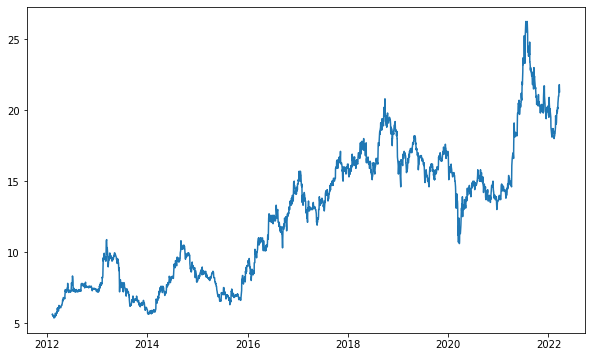

In [8]:
# Visualize BCH price
plt.figure(figsize=(10,6))
plt.plot(df)

In [9]:
# Split close price and return
def window_return(val, window):
  lst_x = []
  lst_y = []
  lst_x_return = []
  lst_y_return = []
  for i in range(0,len(val) - window -1,1):
    first_price = val[i]
    lst_x.append(val[i:i+window])
    lst_y.append(val[i+window])
    lst_x_return.append((val[i+1:i+window]-first_price)/first_price)
    lst_y_return.append((val[i+window]-first_price)/first_price)
  array_x_return = np.array(lst_x_return).reshape(-1,window-1)
  array_y_return = np.array(lst_y_return).reshape(-1,1)
  array_x = np.array(lst_x).reshape(-1,window)
  array_y = np.array(lst_y).reshape(-1,1)
  return array_x,array_x_return,array_y,array_y_return

In [10]:
x_close,encoder_x,y_close,ynext = window_return(df['Last Price'].values, 20)
ynext = ynext.flatten()
print(f"x_close.shape : {x_close.shape}")
print(f"x_return.shape : {encoder_x.shape}")
print(f"y_close.shape : {y_close.shape}")
print(f"y_return.shape : {ynext.shape}")

x_close.shape : (2448, 20)
x_return.shape : (2448, 19)
y_close.shape : (2448, 1)
y_return.shape : (2448,)


Split the dataset in to train/val/test sets

In [11]:
n_data = encoder_x.shape[0]

In [12]:
n_train = int(n_data*0.8)           # 80% in train set
n_test = int(n_data*0.1)            # 10% in test set
n_val = n_data - n_train - n_test   # 10% in validation set

encoder_x_train, ynext_train = encoder_x[:n_train], ynext[:n_train]
encoder_x_val, ynext_val = encoder_x[n_train:n_train+n_val], ynext[n_train:n_train+n_val]
encoder_x_test, ynext_test = encoder_x[n_train+n_val:], ynext[n_train+n_val:]

encoder_x_train.shape, ynext_train.shape, encoder_x_val.shape, ynext_val.shape, encoder_x_test.shape, ynext_test.shape

((1958, 19), (1958,), (246, 19), (246,), (244, 19), (244,))

In [13]:
x_close_train, y_close_train = x_close[:n_train], y_close[:n_train]
x_close_val, y_close_val = x_close[n_train:n_train+n_val], y_close[n_train:n_train+n_val]
x_close_test, y_close_test = x_close[n_train+n_val:], y_close[n_train+n_val:]

x_close_train.shape, y_close_train.shape, x_close_val.shape, y_close_val.shape, x_close_test.shape, y_close_test.shape

((1958, 20), (1958, 1), (246, 20), (246, 1), (244, 20), (244, 1))

## 3.2 Prepare the 1-step outputs (`decoder_y`)

In [15]:
n_output_timesteps = 1      # how many time step ahead to predict
# Create 'decoder_y' from 'ynext'
decoder_y_train = np.zeros((ynext_train.shape[0], n_output_timesteps), dtype=ynext_train.dtype)
decoder_y_test = np.zeros((ynext_test.shape[0], n_output_timesteps), dtype=ynext_test.dtype)
decoder_y_val = np.zeros((ynext_val.shape[0], n_output_timesteps), dtype=ynext_val.dtype)
decoder_y_train[:,0] = ynext_train[:]
decoder_y_test[:,0] = ynext_test[:]
decoder_y_val[:,0] = ynext_val[:]
for i in range(1, n_output_timesteps):
  decoder_y_train[:,i] = decoder_y_train[:, i-1] + 2
  decoder_y_test[:,i] = decoder_y_test[:, i-1] + 2
  decoder_y_val[:,i] = decoder_y_val[:, i-1] + 2

print('encoder_x_train.shape={}, decoder_y_train.shape={}'.format(encoder_x_train.shape, decoder_y_train.shape))
print('encoder_x_val.shape={}, decoder_y_val.shape={}'.format(encoder_x_val.shape, decoder_y_val.shape))
print('encoder_x_test.shape={}, decoder_y_test.shape={}'.format(encoder_x_test.shape, decoder_y_test.shape))

encoder_x_train.shape=(1958, 19), decoder_y_train.shape=(1958, 1)
encoder_x_val.shape=(246, 19), decoder_y_val.shape=(246, 1)
encoder_x_test.shape=(244, 19), decoder_y_test.shape=(244, 1)


## 3.3 Normalize the data

In [16]:
from sklearn.preprocessing import MinMaxScaler

# Min-max scaling to normalize the data to the range [0, 1]
# .fit_transform expects 2D input
minmax_norm = MinMaxScaler().fit(encoder_x_train.reshape(-1, 1))
print('Dataset min-max:', minmax_norm.data_min_, minmax_norm.data_max_)

encoder_x_train_norm = minmax_norm.transform(encoder_x_train.reshape(-1, 1)).reshape(encoder_x_train.shape)
decoder_y_train_norm = minmax_norm.transform(decoder_y_train.reshape(-1, 1)).reshape(decoder_y_train.shape)
encoder_x_test_norm = minmax_norm.transform(encoder_x_test.reshape(-1, 1)).reshape(encoder_x_test.shape)
decoder_y_test_norm = minmax_norm.transform(decoder_y_test.reshape(-1, 1)).reshape(decoder_y_test.shape)
encoder_x_val_norm = minmax_norm.transform(encoder_x_val.reshape(-1, 1)).reshape(encoder_x_val.shape)
decoder_y_val_norm = minmax_norm.transform(decoder_y_val.reshape(-1, 1)).reshape(decoder_y_val.shape)

Dataset min-max: [-0.26153846] [0.32352941]


## 3.4 Prepare the decoder's input (`decoder_x`) according to Teacher Forcing

In [17]:
def gen_decoder_x(decoder_y_train, decoder_y_test, decoder_y_val, start_token=-0.1):
  # Initial all with zeros
  decoder_x_train = np.zeros_like(decoder_y_train)
  decoder_x_test = np.zeros_like(decoder_y_test)
  decoder_x_val = np.zeros_like(decoder_y_val)

  # Set the start token for the first time step
  decoder_x_train[:,0] = start_token
  decoder_x_test[:,0] = start_token
  decoder_x_val[:,0] = start_token

  # Teacher forcing
  n_timesteps = decoder_y_train.shape[-1]
  decoder_x_train[:,1:] = decoder_y_train[:,0:n_timesteps-1]
  decoder_x_test[:,1:] = decoder_y_test[:,0:n_timesteps-1]
  decoder_x_val[:,1:] = decoder_y_val[:,0:n_timesteps-1]

  return decoder_x_train, decoder_x_test, decoder_x_val

start_token = -0.1 # the start of sequence for teacher forcing

gen_results = gen_decoder_x(decoder_y_train_norm, decoder_y_test_norm, decoder_y_val_norm, start_token=start_token)
decoder_x_train_norm, decoder_x_test_norm, decoder_x_val_norm = gen_results

Format the data according to `seq2seq_model`'s requirements

In [18]:
print('Dimension before changed:')
print(encoder_x_train_norm.shape)
print(decoder_x_train_norm.shape)
print(decoder_y_train_norm.shape)
print(encoder_x_val_norm.shape)
print(decoder_x_val_norm.shape)
print(decoder_y_val_norm.shape)
print(encoder_x_test_norm.shape)
print(decoder_x_test_norm.shape)
print(decoder_y_test_norm.shape)

encoder_x_train_norm = np.expand_dims(encoder_x_train_norm, axis=2)
decoder_x_train_norm = np.expand_dims(decoder_x_train_norm, axis=2)
decoder_y_train_norm = np.expand_dims(decoder_y_train_norm, axis=2)
encoder_x_val_norm = np.expand_dims(encoder_x_val_norm, axis=2)
decoder_x_val_norm = np.expand_dims(decoder_x_val_norm, axis=2)
decoder_y_val_norm = np.expand_dims(decoder_y_val_norm, axis=2)
encoder_x_test_norm = np.expand_dims(encoder_x_test_norm, axis=2)
decoder_x_test_norm = np.expand_dims(decoder_x_test_norm, axis=2)
decoder_y_test_norm = np.expand_dims(decoder_y_test_norm, axis=2)

print('\nDimension after chenged:')
print(encoder_x_train_norm.shape)
print(decoder_x_train_norm.shape)
print(decoder_y_train_norm.shape)
print(encoder_x_val_norm.shape)
print(decoder_x_val_norm.shape)
print(decoder_y_val_norm.shape)
print(encoder_x_test_norm.shape)
print(decoder_x_test_norm.shape)
print(decoder_y_test_norm.shape)

# Convert everything to the default of float32
encoder_x_train_norm = encoder_x_train_norm.astype(np.float32)
decoder_x_train_norm = decoder_x_train_norm.astype(np.float32)
decoder_y_train_norm = decoder_y_train_norm.astype(np.float32)
encoder_x_val_norm = encoder_x_val_norm.astype(np.float32)
decoder_x_val_norm = decoder_x_val_norm.astype(np.float32)
decoder_y_val_norm = decoder_y_val_norm.astype(np.float32)
encoder_x_test_norm = encoder_x_test_norm.astype(np.float32)
decoder_x_test_norm = decoder_x_test_norm.astype(np.float32)
decoder_y_test_norm = decoder_y_test_norm.astype(np.float32)

Dimension before changed:
(1958, 19)
(1958, 1)
(1958, 1)
(246, 19)
(246, 1)
(246, 1)
(244, 19)
(244, 1)
(244, 1)

Dimension after chenged:
(1958, 19, 1)
(1958, 1, 1)
(1958, 1, 1)
(246, 19, 1)
(246, 1, 1)
(246, 1, 1)
(244, 19, 1)
(244, 1, 1)
(244, 1, 1)


# 4. Compile and train the model

## 4.1 Save the best models

In [19]:
checkpoint_filepath = 'Group_HW3_bestmodel_epoch{epoch:03d}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=False,
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True)

In [20]:
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self, encoder, decoder):
    super().__init__()

    # The encoder and decoder models to be saved
    self.encoder = encoder
    self.decoder = decoder

    self.min_valloss = None
    self.start_time = None
  
  def on_train_begin(self, logs=None):
    self.start_time = time.time()
    self.min_valloss = None
  
  def on_epoch_end(self, epoch, logs=None):
    # Compute the total runtime since the training started
    total_run_time = int(time.time() - self.start_time)
    msg = f' Train time {datetime.timedelta(seconds=total_run_time)}'
    # Save the best encoder and decoder models
    if 'val_loss' in logs.keys():
      if self.min_valloss is None:
        self.min_valloss = logs['val_loss']
      if logs['val_loss'] < self.min_valloss:
        self.min_valloss = logs['val_loss']
        self.encoder.save('Group_HW3_bestencoder.hdf5')
        self.decoder.save('Group_HW3_bestdecoder.hdf5')
        msg += ' **best'
    
    # Print total run time at the beginning of each epoch's log
    print(msg, end='-')

my_callback = CustomCallback(encoder_model, decoder_model)

## 4.2 Compile and train

In [21]:
nadam = tf.keras.optimizers.Nadam(learning_rate=0.0001)
seq2seq_model.compile(loss='mse', optimizer=nadam, metrics=['mean_absolute_error'])

In [22]:
# Surpass TF's warning messages
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Train the unified model
hist = seq2seq_model.fit([encoder_x_train_norm, decoder_x_train_norm], decoder_y_train_norm,
                         validation_data=([encoder_x_val_norm, decoder_x_val_norm], decoder_y_val_norm),
                         batch_size=64, epochs=30, callbacks=[model_checkpoint_callback, my_callback],
                         verbose=2
                         )

Epoch 1/30
 Train time 0:00:04-31/31 - 4s - loss: 0.2928 - mean_absolute_error: 0.4978 - val_loss: 0.1638 - val_mean_absolute_error: 0.3841 - 4s/epoch - 142ms/step
Epoch 2/30
 Train time 0:00:04 **best-31/31 - 0s - loss: 0.1338 - mean_absolute_error: 0.3083 - val_loss: 0.0556 - val_mean_absolute_error: 0.2116 - 387ms/epoch - 12ms/step
Epoch 3/30
 Train time 0:00:05 **best-31/31 - 0s - loss: 0.0664 - mean_absolute_error: 0.2018 - val_loss: 0.0231 - val_mean_absolute_error: 0.1204 - 403ms/epoch - 13ms/step
Epoch 4/30
 Train time 0:00:05 **best-31/31 - 0s - loss: 0.0473 - mean_absolute_error: 0.1706 - val_loss: 0.0160 - val_mean_absolute_error: 0.0932 - 375ms/epoch - 12ms/step
Epoch 5/30
 Train time 0:00:06 **best-31/31 - 0s - loss: 0.0388 - mean_absolute_error: 0.1551 - val_loss: 0.0142 - val_mean_absolute_error: 0.0866 - 385ms/epoch - 12ms/step
Epoch 6/30
 Train time 0:00:06 **best-31/31 - 0s - loss: 0.0377 - mean_absolute_error: 0.1517 - val_loss: 0.0125 - val_mean_absolute_error: 0.08

In [23]:
hist.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

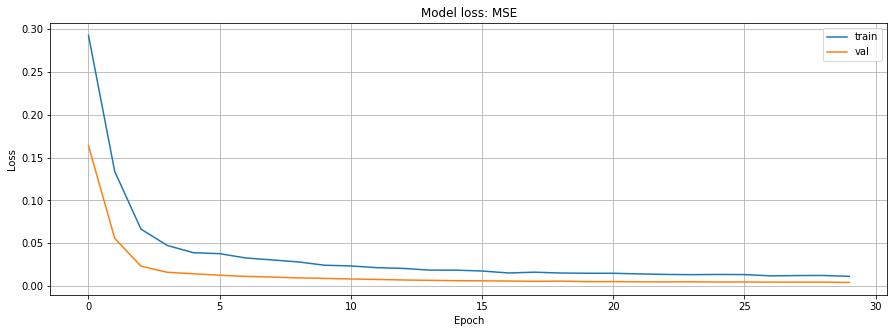

In [24]:
# Plot training & validation loss values
plt.figure(figsize=(15,5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss: MSE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

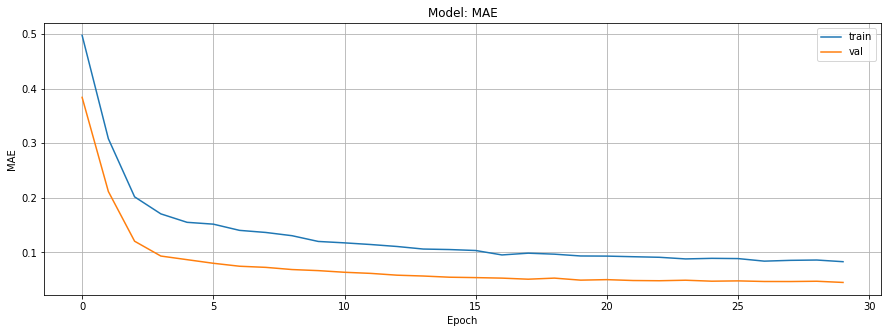

In [25]:
# Plot training & validation evaluation values
plt.figure(figsize=(15,5))
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('Model: MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

# 5. Evaluation

In [26]:
# Load the model from the best epoch (minimum val_loss)
import os
bestmodel_path = max([f for f in os.listdir('.') if f.startswith('Group_HW3_bestmodel_') and f.endswith('.hdf5')])
print(f'The best model: {bestmodel_path}')

best_model = tf.keras.models.load_model(bestmodel_path, compile=True)

The best model: Group_HW3_bestmodel_epoch030.hdf5


In [36]:
# Evaluate the model from the last epoch
score = seq2seq_model.evaluate([encoder_x_test_norm, decoder_x_test_norm], decoder_y_test_norm, verbose=0)
if hasattr(score,'__len__'):
  print('The results (model from the last epoch):', [(seq2seq_model.metrics_names[i], score[i]) for i in range(len(score))])
else:
  print('The results (model from the last epoch):', (seq2seq_model.metrics_names[0], score))

# Evaluate the model from the best epoch
score = best_model.evaluate([encoder_x_test_norm, decoder_x_test_norm], decoder_y_test_norm, verbose=0)
if hasattr(score,'__len__'):
  print('The results (model from the best epoch):', [(best_model.metrics_names[i], score[i]) for i in range(len(score))])
else:
  print('The results (model from the best epoch):', (best_model.metrics_names[0], score))

The results (model from the last epoch): [('loss', 0.0048970188945531845), ('mean_absolute_error', 0.05407463014125824)]
The results (model from the best epoch): [('loss', 0.0048970188945531845), ('mean_absolute_error', 0.05407463014125824)]


# 6. Inference

## 6.1 Load the best encoder and decoder models

In [28]:
# Load the encoder and decoder models corresponding to the best epoch (minimum val_loss)
best_encoder = tf.keras.models.load_model('Group_HW3_bestencoder.hdf5', compile=False)
best_decoder = tf.keras.models.load_model('Group_HW3_bestdecoder.hdf5', compile=False)

## 6.2 Define a function for autoregressive decoding

In [29]:
def autoregressive_decode(encoder_inf, decoder_inf, input_seq, n_step_out, n_out_feature=1, start_token=0):
  '''
  Input argruments:
    encoder_inf (model): the encoder model to be used during inferencing
    decoder_int (model): the decoder model to be used during inferencing
    input_seq (a sequence of numbers): an input sequence (input_dim=1) for the model to predict the next numbers
    n_step_out (int): for how many output time step that the model should predict
    n_out_feature (int): the number of features for one output (in our example, it is 1)
  '''
  # Encode
  state = encoder_inf.predict(input_seq)
  # Create the first input of the decoder (= the start token)
  target_seq = np.zeros(n_out_feature).reshape(1,1,n_out_feature)
  target_seq[0,0,:] = start_token
  # Collect predictions from autoreqressive decoding
  output = []
  for t in range(n_step_out):
    # Predict the next number
    y_pred, state = decoder_inf.predict([target_seq,state])

    # Store prediction
    output.append(y_pred[0,0,:])

    # Update target sequence
    target_seq = y_pred
  
  return np.array(output)

## 6.3 Use autoregressive decoding

Evaluate the models on the test set

In [30]:
n = encoder_x_test.shape[0]
n_step_out = n_output_timesteps
y_pred = []

for i in range(n):
  ypred_norm = autoregressive_decode(best_encoder, best_decoder, np.expand_dims(encoder_x_test_norm[i], axis=0), n_step_out, 1, start_token)
  ypred = minmax_norm.inverse_transform(ypred_norm)
  y_pred.append(ypred.reshape(-1)[0])

In [31]:
# Convert return prediction to price
y_pred = np.array(y_pred).reshape(-1,1)
price_pred = (x_close_test[:,-1].reshape(-1,1) * (1 + y_pred))
price_pred = np.around(price_pred, 2)

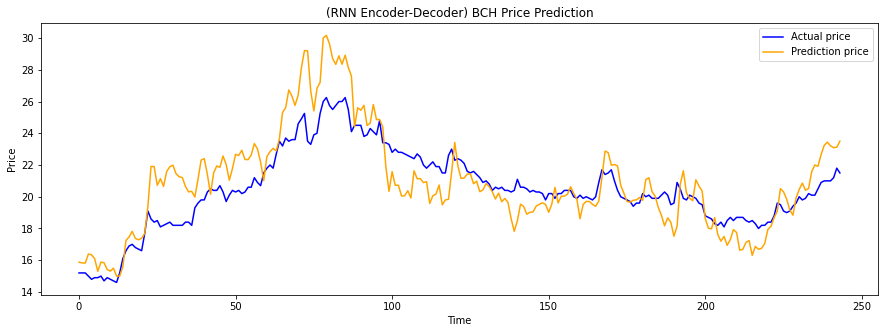

In [32]:
# Visualize the price prediction
plt.figure(figsize=(15,5))
plt.plot(y_close_test, label='Actual price', color='blue')
plt.plot(price_pred, label='Prediction price', color='orange')
plt.title('(RNN Encoder-Decoder) BCH Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [33]:
mse = mean_squared_error(y_close_test, price_pred)
mae = mean_absolute_error(y_close_test, price_pred)

print(f"mean_squared_error : {mse:.4f}")
print(f"mean_absolute_error : {mae:.4f}")

mean_squared_error : 2.8298
mean_absolute_error : 1.3492


In [34]:
prediction = pd.DataFrame(price_pred, columns=['y_pred'])
prediction

,y_pred
0,15.88
1,15.83
2,15.82
3,16.39
4,16.34
...,...
239,23.44
240,23.21
241,23.09
242,23.12


In [35]:
prediction.to_excel('prediction.xlsx')